In [2]:
pip install ijson

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.4/134.4 kB 4.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [10]:
import os
import json
import glob
import re
from pathlib import Path
import torch
import torch.nn as nn
from torchvision import transforms, datasets, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
from collections import Counter, defaultdict
import ijson

In [11]:
from pathlib import Path

def tree(
    path: str | Path,
    indent: int = 0,
    _file=None,
) -> int:
    path = Path(path)
    file_count = 0
    subfolder_counts = []

    close_file = False
    if _file is None:
        _file = open("/kaggle/working/tree.txt", "w", encoding="utf-8")
        close_file = True

    try:
        entries = list(path.iterdir())
    except FileNotFoundError:
        raise FileNotFoundError(f"Chemin introuvable : {path}")
    except PermissionError:
        return 0

    files = [e for e in entries if e.is_file()]
    dirs = [e for e in entries if e.is_dir()]

    file_count = len(files)

    for d in sorted(dirs, key=lambda p: p.name.lower()):
        sub_count = count_files_and_display_tree(
            d,
            indent=indent + 4,
            _file=_file,
        )
        subfolder_counts.append((d, sub_count))

    line = " " * indent + f"{path.name}/ [{file_count} fichiers]\n"
    if _file is not None:
        _file.write(line)

    for subfolder, sub_count in subfolder_counts:
        sub_line = " " * (indent + 2) + f"{subfolder.name}/ [{sub_count} fichiers]\n"
        if _file is not None:
            _file.write(sub_line)

    total_files = file_count + sum(count for _, count in subfolder_counts)

    if close_file and _file is not None:
        _file.close()

    return total_files

Cette fonction parcourt récursivement l'arborescence du dossier passé en argument. Utile pour vérifier le bon transfert des fichiers, en utilisant un programme permettant la comparaison de l'arborescence exportée avec celle exécutée localement avant l'upload du dataset. Ayant eu des coupures d'Internet durant l'upload, il fallait que je m'assure que les fichiers aient tous été correctement transférés.

Note : Ce programme n'a pas pour but de vérifier l'intégrité des images, ce qui se révélera être un vrai problème par la suite. En effet, avec les interruptions d'Internet, certaines images ont été corrompues durant le transfert, et il m'a fallu longtemps avant de m'en rendre compte.

---

<div style="text-align: center;">
    <img src="https://github.com/Open-Insect-Id/dataset/blob/main/taxonomie_schema.webp?raw=true" width="500" alt="Classification taxonomique">
</div>

---

Image représentant la **classification taxonomique**, qui permet d'atteindre une **précision maximale**, et également de **réduire l'erreur** : si le modèle se trompe sur l'espèce, l'ordre, la famille et le genre ont de fortes chances d'être corrects, réduisant ainsi l'impact de l'erreur, par rapport à un modèle qui ne prédirait que l'espèce finale.
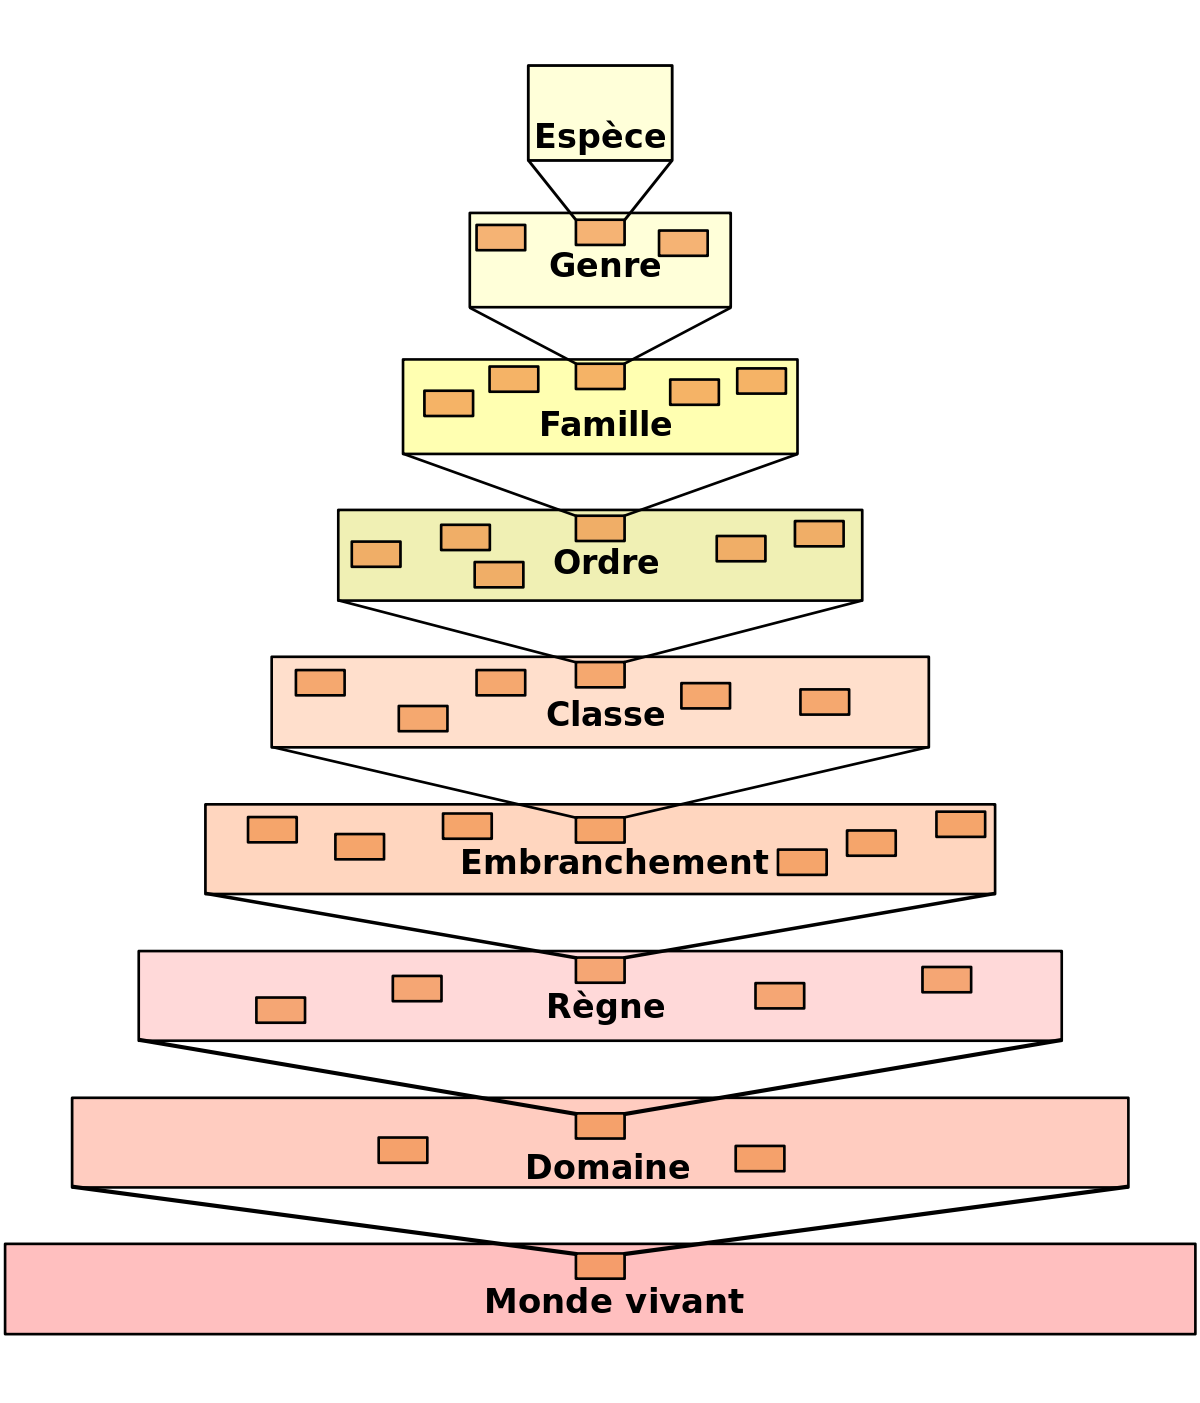
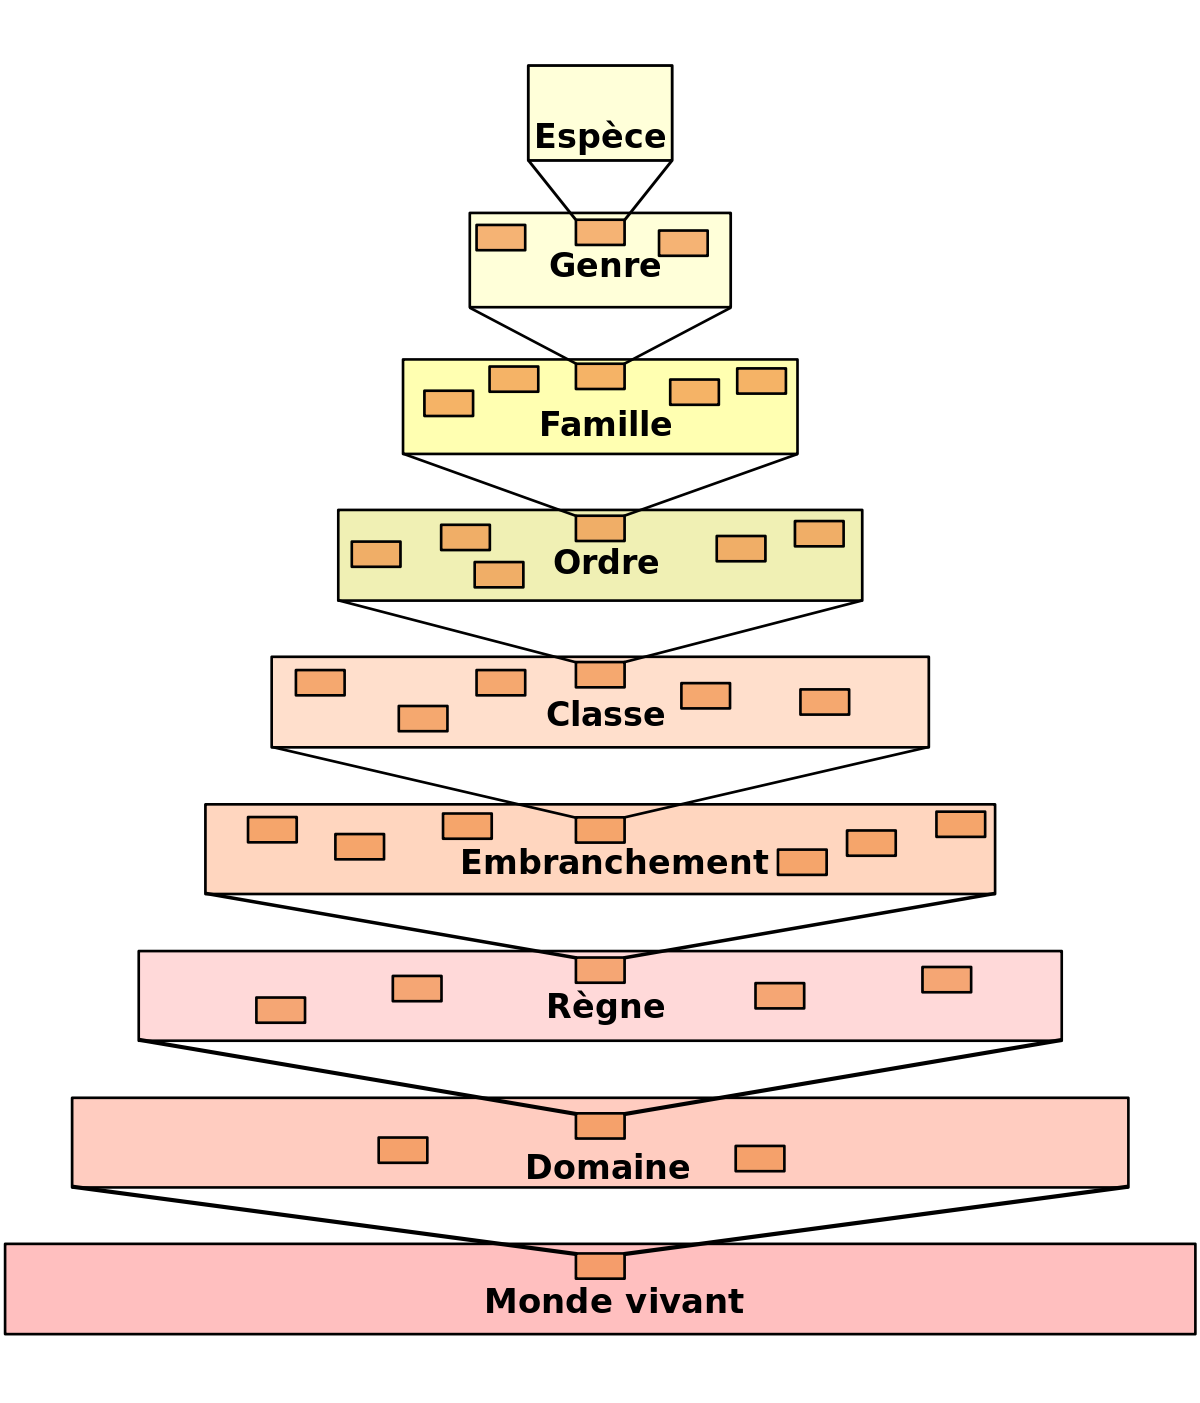
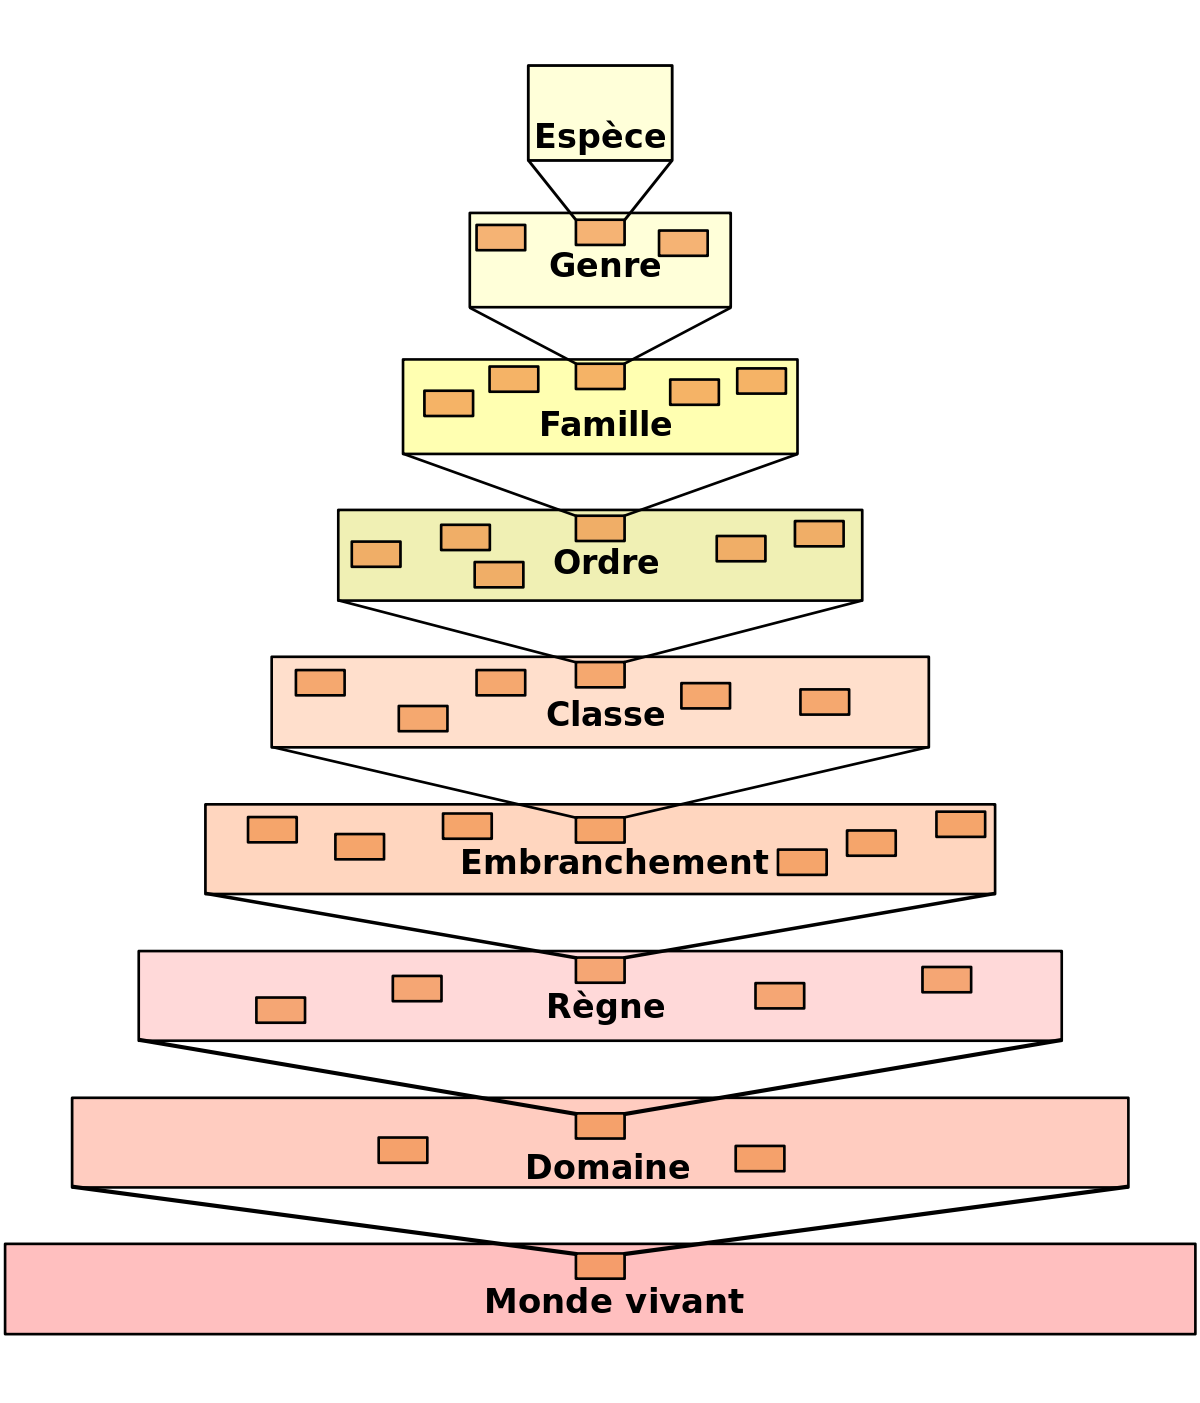
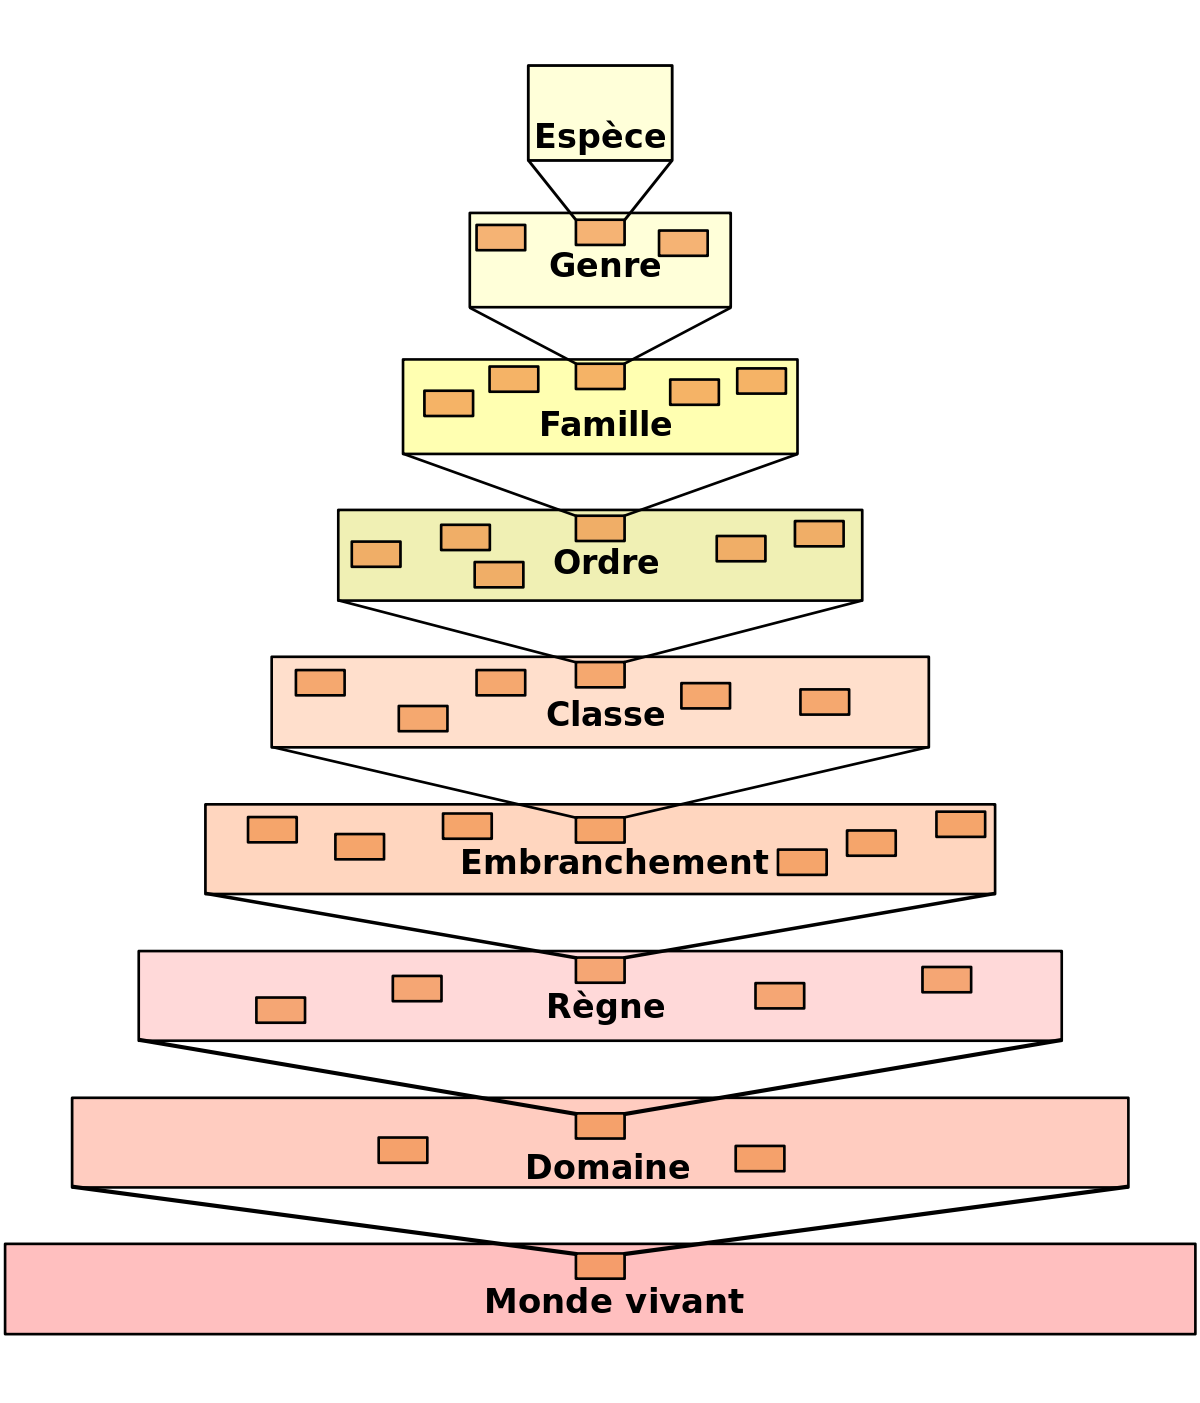
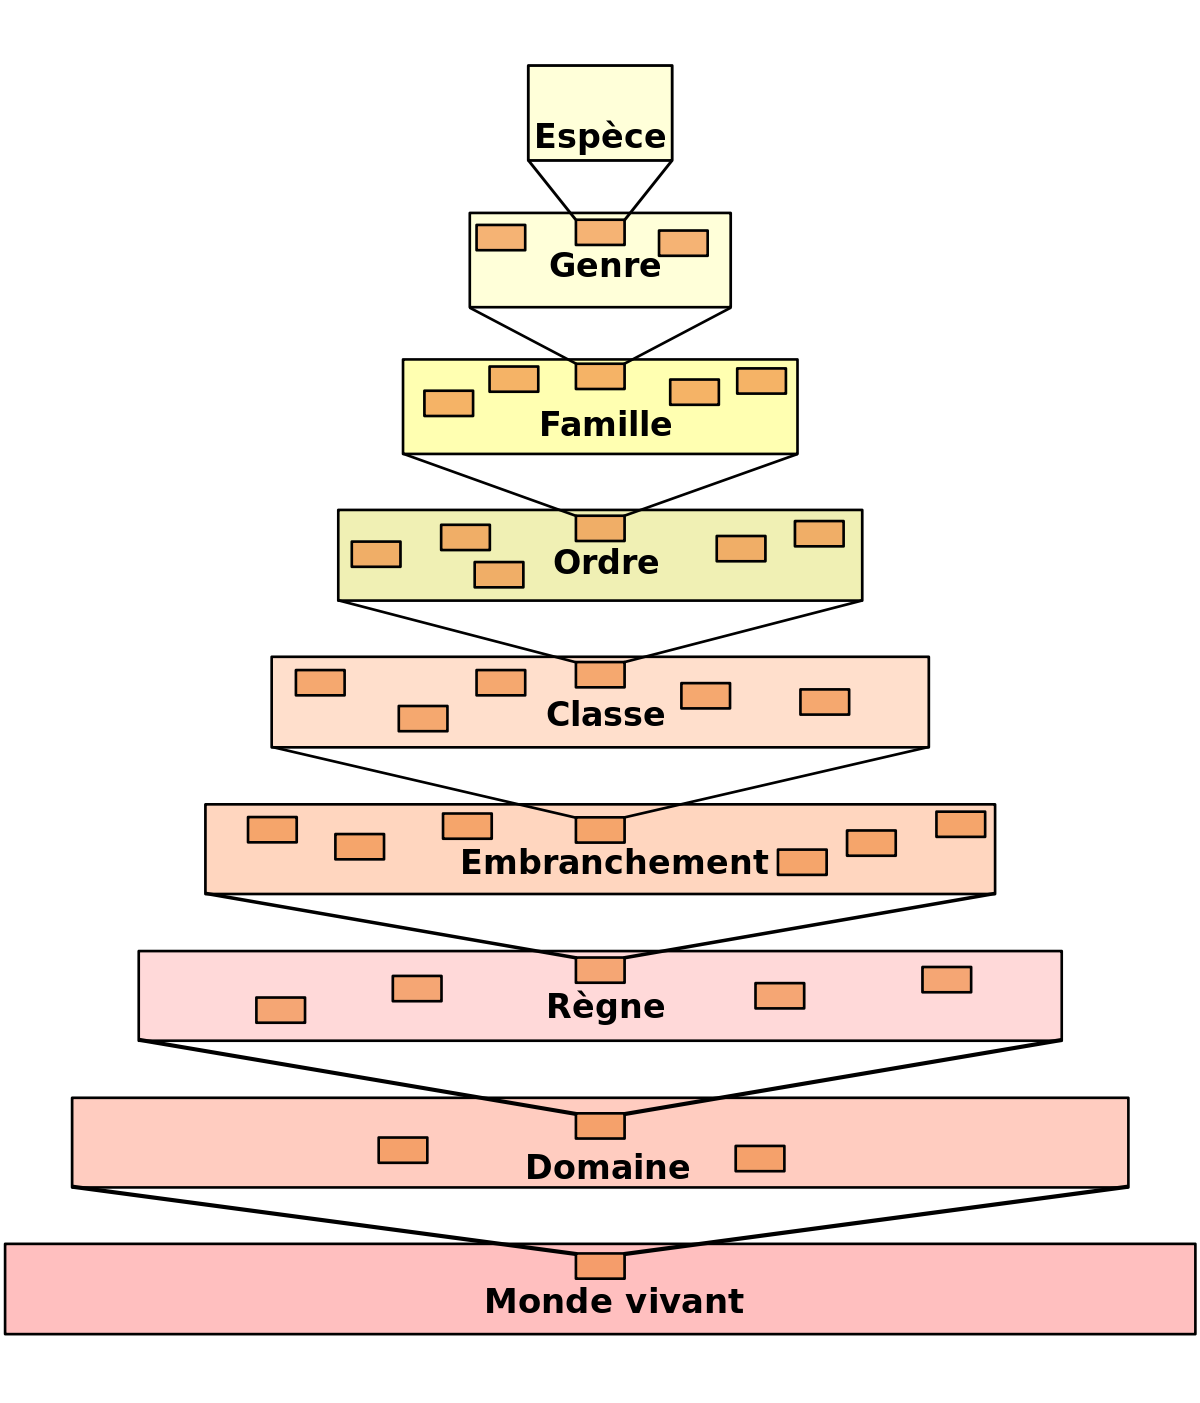
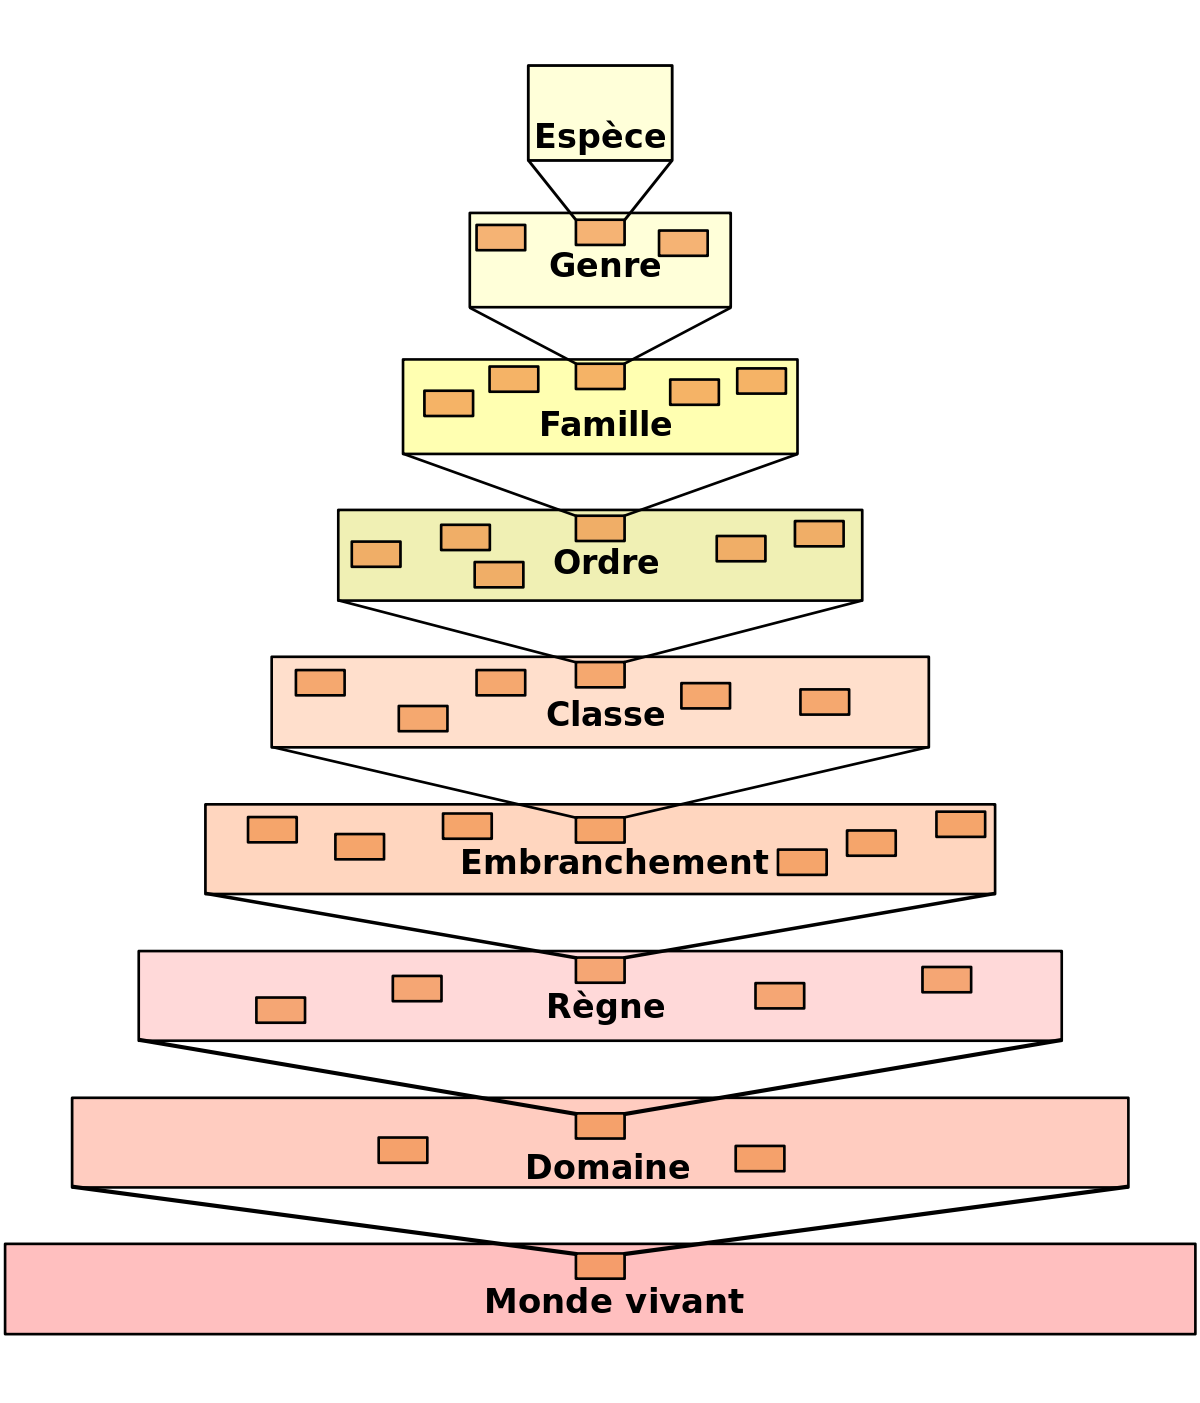
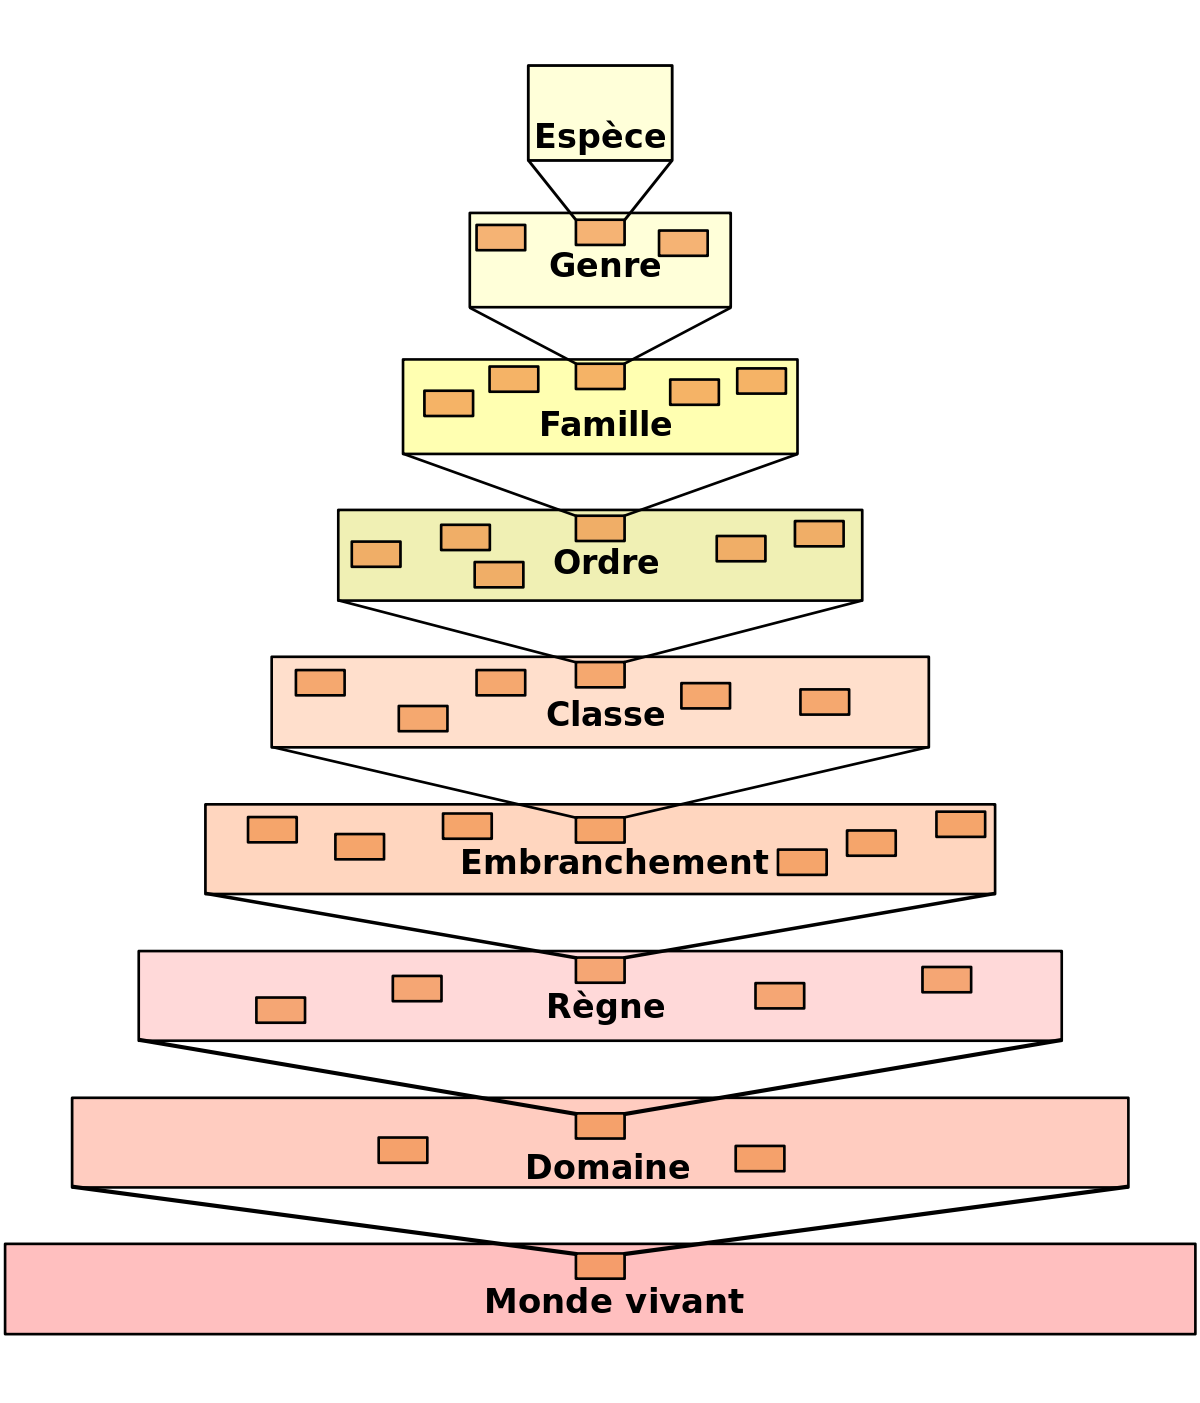
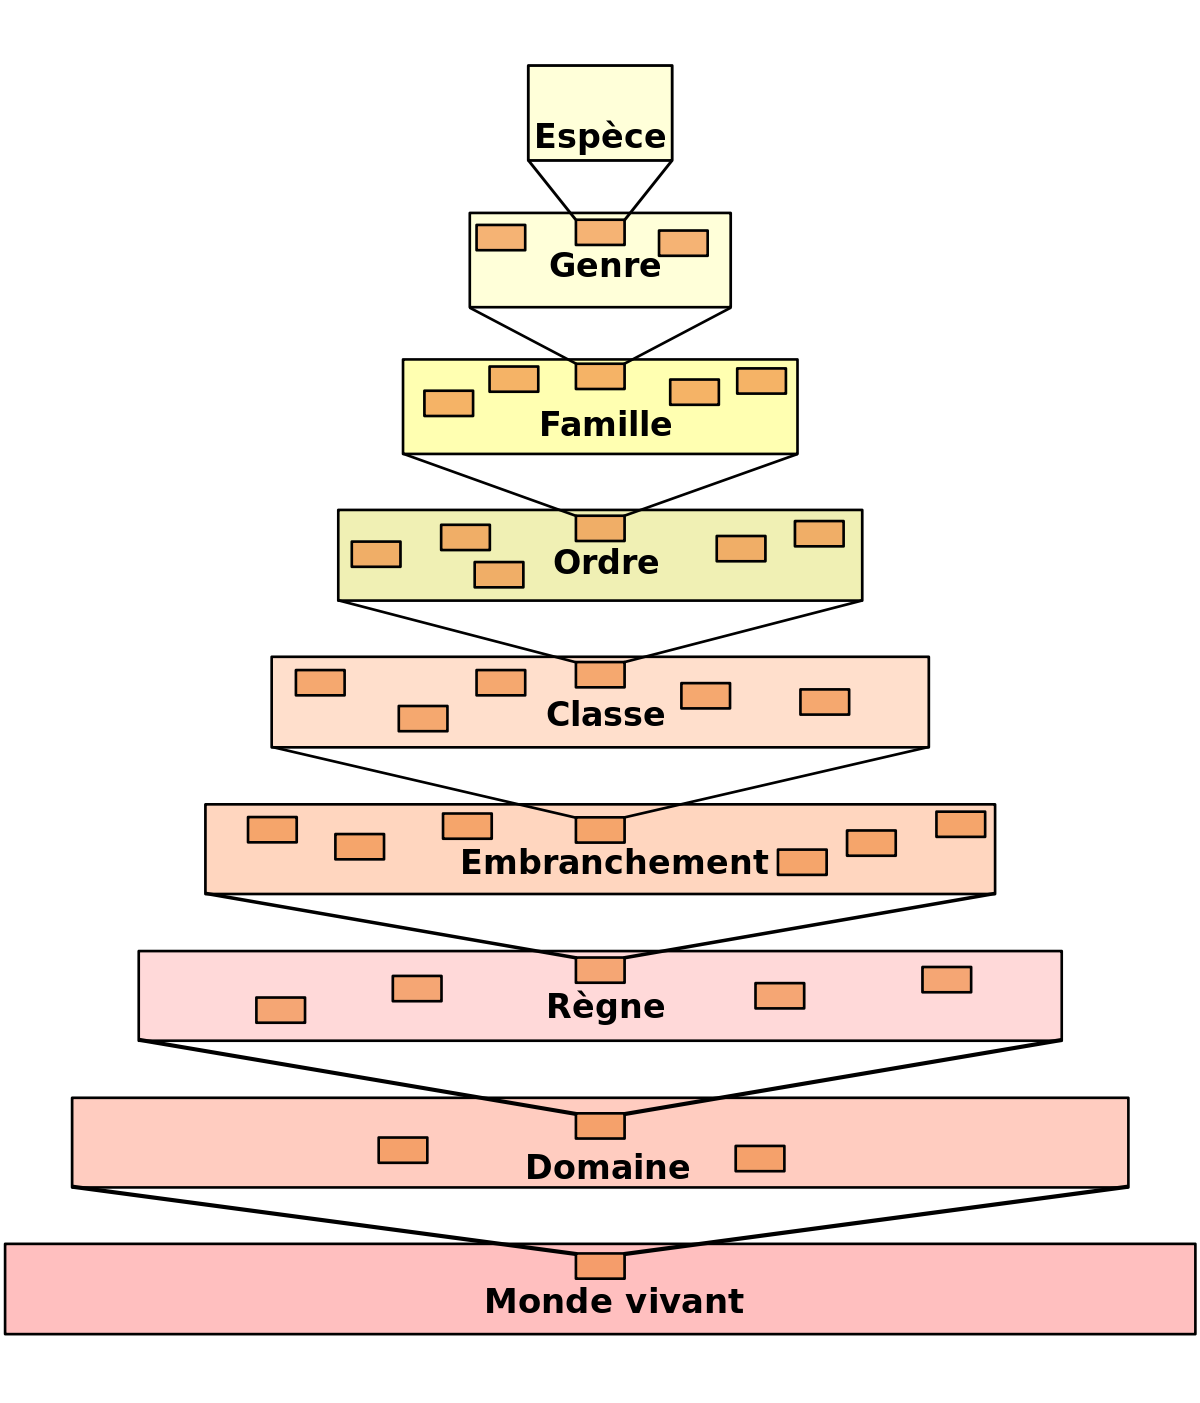

In [12]:
import re

def parse_taxonomy(filepath):
    match = re.search(r'train/train/([^/]+)/[^/]+\.jpg$', filepath)
    if not match:
        print(f"Regex ne correspond pas : {filepath}")
        return None
    folder = match.group(1)
    taxonomy_path = folder.split('_')
    if len(taxonomy_path) >= 7:
        return {
            'ordre': taxonomy_path[4],  
            'famille': taxonomy_path[5],
            'genre': taxonomy_path[6],
            'espece': taxonomy_path[7]
        }
    return None

**Voici un exemple de chemin de fichier d'une image, depuis laquelle nous extrayons la classification taxonomique.**

```train/train/00980_Animalia_Arthropoda_Insecta_Lepidoptera_Erebidae_Arctia_virginalis/464f3a34-4c04-4eb3-afa2-6cb7444c3fa3.jpg```

Ici nous avons un insecte (critère ayant permis de ne sélectionner que les insectes du dataset original), de l'ordre **Lepidoptera**, de la famille **Erebidae**, de genre **Arctia** et d'espèce **virginalis**. Si nous avions choisi de ne sauver que l'espèce, le modèle aurait peut-être gagné un peu en précision (moins de données à absorber) mais en cas d'erreur du modèle, rien n'aurait alors été vrai. Dans une logique de réduction de l'impact de l'erreur, nous choisirons donc de conserver **4 informations taxonomiques** : **l'ordre**, **la famille**, **le genre** et **l'espèce**.
Nous nommerons par la suite ***'taxon'*** le groupe d'informations taxonomiques.

Dans un premier temps la fonction extrait le nom du dossier parent de l'image, car le nom de l'image en elle-même ne contient pas d'informations.

Taxon folder: ```00980_Animalia_Arthropoda_Insecta_Lepidoptera_Erebidae_Arctia_virginalis```

Bien, il nous suffit maintenant d'extraire les informations taxonomiques de ce nom, à l'aide de la méthode split(), qui retourne une liste, dont les éléments sont ici séparés par un *underscore* (_). Les informations 0 (ID unique), 1, 2, 3 (constantes sur ce dataset filtré) ne nous intéressent pas, nous nous contentons alors de créer un dictionnaire avec les clés suivantes : `ordre`, `famille`, `genre` et `espece`.

Résultat: {'ordre': 'Lepidoptera', 'famille': 'Erebidae', 'genre': 'Arctia', 'espece': 'virginalis'}

In [13]:
from PIL import Image

def verify_image_validy(filepath):
    filepath = "/kaggle/input/inaturalist-insects/"+filepath
    try:
        with Image.open(filepath) as img:
            img.verify()
        return True
    except (IOError, SyntaxError) as exc:
        print(exc)
        _file = open("/kaggle/working/corrupted_files.txt", "w", encoding="utf-8")
        _file.write(filepath)
        _file.close()
        return False

Cette fonction a été rajoutée ici après un premier entrainement complet, car nous expérimentions alors des erreurs dont l'origine était difficile à trouver : la corruption d'images, qui ayant servies à entrainer le modèle, introduisait des erreurs dans les prédictions, par exemple en donnant un ordre et une famille, puis un genre et une espèce n'existant pas sous la famille donnée. Il s'avère que nous ne pouvons malheureusement pas éliminer ces images du dataset, puisque c'est l'une des limitations de Kaggle, le dossier qui sert d'input est en lecture seule. Pour contourner le problème, nous allons alors écrire dans un fichier la liste des fichiers corrompus par avance, puis lors de l'entrainement final, nous ajouterons une vérification pour ne pas traiter les images dont le chemin apparait dans cette liste. 

In [14]:
example = "train/train/00980_Animalia_Arthropoda_Insecta_Lepidoptera_Erebidae_Arctia_virginalis/464f3a34-4c04-4eb3-afa2-6cb7444c3fa3.jpg"
taxonomy = parse_taxonomy(example)
print("Résultat:", taxonomy)
validity = verify_image_validy(example)
print("Image valide" if validity else "Image invalide")

Résultat: {'ordre': 'Lepidoptera', 'famille': 'Erebidae', 'genre': 'Arctia', 'espece': 'virginalis'}
Image valide


In [16]:
base_folder = "/kaggle/input/inaturalist-insects/train_mini"
total = tree(base_folder, 2)
print(f"\nNombre total de fichiers : {total}")


Nombre total de fichiers : 126300


In [ ]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

data_dir = '/kaggle/input/inaturalist-insects/'  

train_transforms = transforms.Compose([
    transforms.RandomRotation(30),        # Rotation aléatoire jusqu'à 30 degrés
    transforms.RandomHorizontalFlip(),    # Flip horizontal aléatoire
    transforms.RandomVerticalFlip(),      # Flip vertical aléatoire
    transforms.RandomResizedCrop(224),    # Recadrage aléatoire et redimensionnement à 224x224
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Ajustements couleurs
    transforms.ToTensor(),                 # Conversion en tenseur PyTorch
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalisation ImageNet
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train/train'), transform=train_transforms)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val/val'), transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f'Nombre de classes: {len(train_dataset.classes)}')
print(f'Taille train dataset: {len(train_dataset)}')
print(f'Taille val dataset: {len(val_dataset)}')

In [ ]:
for images, labels in train_loader:
    print(images.shape)
    assert images.shape == [32, 3, 224, 224] 
    print(labels.shape)
    assert labels.shape == [32]
    break